# Example of when Bootstrapping can go wrong

In this example we will create a a situation where the bootstrap is not going to work so well. 

For a more thurough explanation please see this external reference on [When the bootstrap dosen't work](http://notstatschat.tumblr.com/post/156650638586/when-the-bootstrap-doesnt-work).

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import numpy.random as npr

In [2]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.power as bs_power

### Visual Intuition
The bootstrap is based on a sample of your larger population. A sample is only as good as how representitave it is. If you happen to be unlucky in your sample then you are going to make some very bad inferences. 

One way to improve the representitiveness of our sample is to boost the number of samples we take. Lets see this visually.

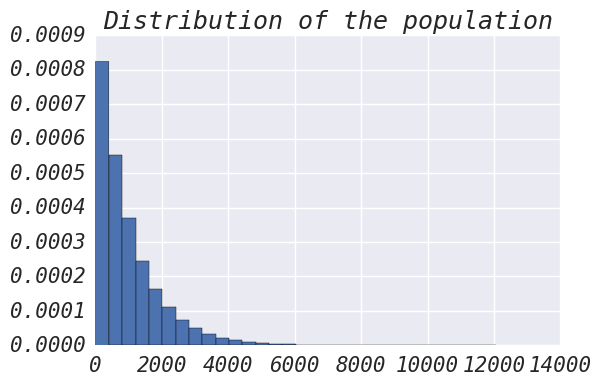

In [3]:
population = np.random.exponential(scale=1000, size=500000)

# Plot the population
count, bins, ignored = plt.hist(population, 30, normed=True)

plt.title('Distribution of the population')
plt.show()

In [4]:
population = pd.Series(population)

In [5]:
def plot_sample_means(population, num_samples):

    sample_means = []
    for i in range(100):
        sample = population.sample(num_samples, replace=True)
        sample_means.append(sample.mean())

    pd.Series(sample_means).plot()
    print('Standard Deviation %f' % pd.Series(sample_means).std())

Standard Deviation 108.035411


(700, 1300)

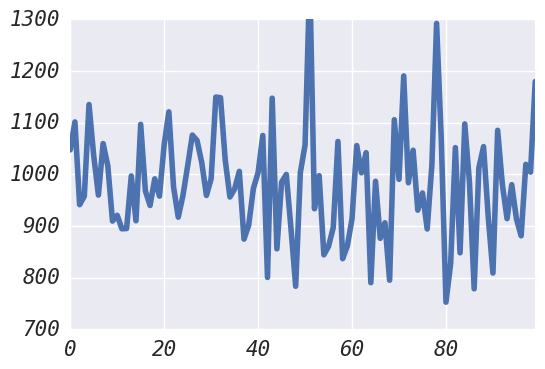

In [6]:
plot_sample_means(population, 100)
plt.ylim(700, 1300)

Standard Deviation 29.979785


(700, 1300)

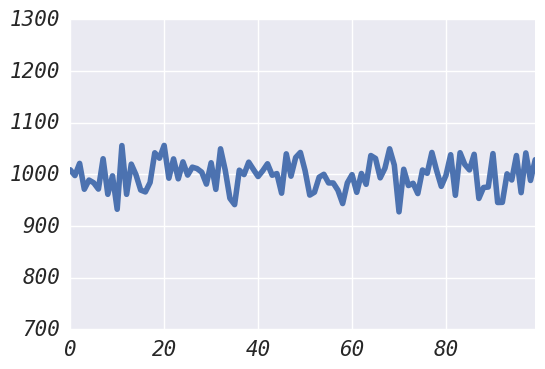

In [7]:
plot_sample_means(population, 1000)
plt.ylim(700, 1300)

Standard Deviation 9.383124


(700, 1300)

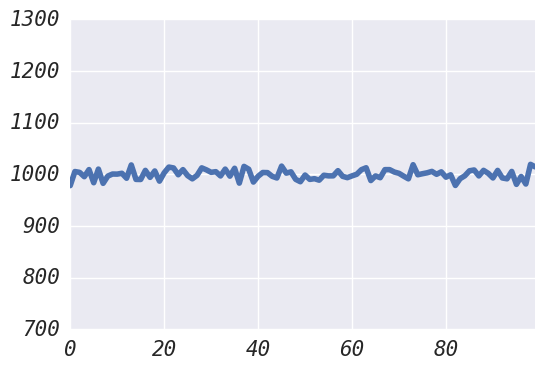

In [8]:
# Pretty representative
plot_sample_means(population, 10000)
plt.ylim(700, 1300)

**Wow!** So we can visually see how our estimate of the mean gets more stable the more samples we take.

## The worst.


Now that you have a sense for how sample size impacts error in estimating the mean - lets create a scenario that is even more extreme.

Above we looked at an exponential distribution which can generate some rare extreme outliers (which hurt our estimation ability).

Lets create a poulation where things are even more extreme.

In [9]:
bad_population = pd.Series([1]*10000 + [100000])

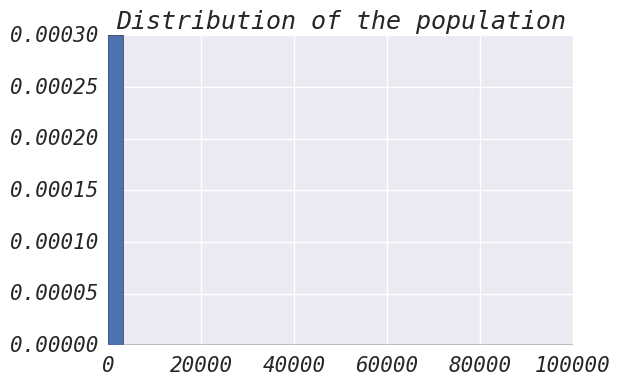

In [10]:
# Plot the population
count, bins, ignored = plt.hist(bad_population, 30, normed=True)

plt.title('Distribution of the population')
plt.show()

Standard Deviation 35.618275


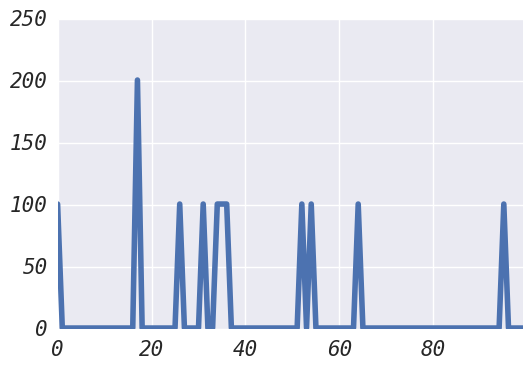

In [11]:
# uh oh... 
plot_sample_means(bad_population, 1000)

In [12]:
# Yikes! Our bootstrap interval is very tight but it is also completley off!
# This is a 'worst case' scenario for doing the bootstrap
# It looks like we happened to take a sample where there was no extreme value
samples = bad_population.sample(1000)

print(bad_population.mean())
print(bs.bootstrap(samples.values, stat_func=bs_stats.mean, is_pivotal=False))

10.99890011
1.0    (1.0, 1.0)


In [13]:
# Here we incresed the sample count and got lucky (sampled that single extreme value)
# Note that the error bars on the bootstrap are very wide
samples = bad_population.sample(10000)

print(bad_population.mean())
print(bs.bootstrap(samples.values, stat_func=bs_stats.mean, is_pivotal=False))

10.99890011
10.9999    (1.0, 30.9997)


## Just how often can we expect our error bars to not reflect the true mean?

See the [Power Calculation](https://github.com/facebookincubator/bootstrapped/blob/master/examples/power_calculation.ipynb) example for more information on power.

In [14]:
num_samples = 1000
results = []

bad_population_mean = bad_population.mean()

for _ in range(1000):
    samples = bad_population.sample(num_samples)
    result = bs.bootstrap(samples.values, stat_func=bs_stats.mean)
    
    # we want to 0 center this for our power plotting below
    result = result - bad_population_mean
    
    results.append(result)

In [15]:
# Ideally the sample should have no significant difference from the mean. 
#   This would mean that the bootstrap errorbars overlap the true mean.

# We see here that only 10% of the time we should expect our error bars NOT contain the mean
#  This is bad! 90% of the time our confidence interval wont cover the true mean!
bs_power.power_stats(results)

,Percent
Insignificant,10.500
Negative,89.500
Negative Significant,89.500
Positive,10.500
Positive Significant,0.000


In [16]:
# lets try the above with 10k instead of 1k samples
num_samples = 10000
larger_results = []

bad_population_mean = bad_population.mean()

for _ in range(1000):
    samples = bad_population.sample(num_samples)
    result = bs.bootstrap(samples.values, stat_func=bs_stats.mean)
    
    # we want to 0 center this for our power plotting below
    result = result - bad_population_mean
    
    larger_results.append(result)

In [17]:
# With a larger sample we find the sample's error bars overlap the true mean, this is better
bs_power.power_stats(larger_results)

,Percent
Insignificant,100.000
Negative,0.000
Negative Significant,0.000
Positive,100.000
Positive Significant,0.000
